In [ ]:
#### NRK IMPORTANT TODO: Fix freezing analysis for open field - right now it is reading in the scale factor from the
# Shock arena by default and I think this could be leading to errors.

In [ ]:
# Need to re-run freezing analysis after alignment bug fix - should still be all the same for shock arena 
# but might change for open arena

This notebook holds all development of ICA related analysis.  
  
Road map:  
1) Run ICA on running only PSAbool data from open field day -1. Should be able to identify cells with similar place fields!  Sanity check.  
  
2) Run ICA on circa-freezing data only. Another sanity check. Create boolean of freezing times +/- 2 seconds. Should be able to recover cells I have already identified as freeze cells with freezing_analysis.MotionTuning class.  
  
3) Run ICA on non-filtered PSAbool data. Correlate different component activations with freezing and/or velocity to pull out the "freezing" ensembles on day 1.  
  
3a) Track these ensembles backward and forward one session to see how they develop. Should match single cell findings, but maybe we will see something interesting in the ANI vs. Control stuff?

In [1]:
# Import useful modules
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.gridspec as gridspec
import pandas as pd

In [3]:
# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

from session_directory import find_eraser_directory as get_dir
import er_plot_functions as erp
import Placefields as pf
import freezing_analysis as fa
import helpers 
import eraser_reference as err

# Project save directory here
print_dir = '/Users/nkinsky/Documents/BU/Working/Eraser/plots'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Zeroth, check/fix freezing to PSA alignment.

In [4]:
from os import path
import scipy.io as sio
mouse = 'Marble07'
arena = 'Shock'
day = -2

dir_use = erp.get_dir(mouse, arena, day)
PF = pf.load_pf(mouse, arena, day)

im_data_file = path.join(dir_use, 'FinalOutput.mat')
im_data = sio.loadmat(im_data_file)
PSAbool = im_data['PSAbool']

# Now get behavioral timestamps and freezing times
freezing, velocity, video_t = erp.detect_freezing(str(dir_use), arena=arena, return_time=True)

# Read in recording times from csv timestamp file directly
behave_time_file = sorted(dir_use.glob('**/*Index.csv'))[0]
behave_times = pd.read_csv(behave_time_file, header=None)

# This suggests that I am not aligning things properly!!!
print('Behavioral video time from csv directoy = ' + str(behave_times[0].iloc[-1] - behave_times[0].iloc[0]) 
      + ' seconds')
print('Imaging time before alignment = ' + str(PSAbool.shape[1]/20) + ' seconds')
print('aligned imaging recording time = ' + str(PF.PSAbool_align.shape[1]/20) + ' seconds')
print('behavioral video recording time after alignment = ' + str(video_t[-1] - video_t[0]) + ' seconds')

Behavioral video time from csv directoy = 599.81 seconds
Imaging time before alignment = 599.7 seconds
aligned imaging recording time = 599.55 seconds
behavioral video recording time after alignment = 599.81 seconds


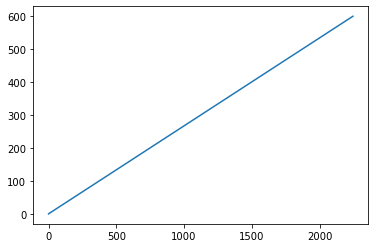

In [5]:
fig, ax = plt.subplots()
ax.plot(video_t)


# First try to recover cells with similar place fields using ICA as a sanity check.

In [5]:
# First define moving average function to smooth things into 1 second
def moving_average(arr, n=20):
    ret = np.cumsum(arr, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def bin_array(arr, n=20):
    return np.add.reduceat(arr, np.arange(0, len(arr), n))


In [6]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA, PCA
mouse = 'Marble07'
arena = 'Shock'
day = -2

# Load in relevant data
PF = pf.load_pf(mouse, arena, day)
PSAboolalign, freeze_bool = fa.get_freeze_bool(mouse, arena, day)
freeze_ind = np.where(freeze_bool)[0]

# First bin events
bin_size = 0.5  # sec
PSAsmooth, PSAbin = [], []
for psa in PF.PSAbool_align:
    PSAsmooth.append(moving_average(psa, int(bin_size*PF.sr_image))) # Create moving-average array
    PSAbin.append(bin_array(psa, int(bin_size*PF.sr_image))) # Create non-overlapping bin array
PSAsmooth = np.asarray(PSAsmooth)
PSAbin = np.asarray(PSAbin)

PSAbinz = stats.zscore(PSAbin, axis=1)

# NRK - do I need to z-score rates here first?

# Now calculate covariance matrix for all your cells using binned array
cov_mat = np.cov(PSAbin)
cov_matz = np.cov(PSAbinz)

# # Run ICA on the two different PSAs
nICs = 20
transformer = FastICA(n_components=20, random_state=0)
cov_trans = transformer.fit_transform(cov_mat)

# Make into a dataframe for easy plotting
ct_df = pd.DataFrame(cov_trans)
ct_df["cell"] = [str(_) for _ in np.arange(0, ct_df.shape[0])]  # Add in cell # to df (Maybe I need to make this a string to work properly for plotting?)
cols = ct_df.columns.to_list()
cols = cols[-1:] + cols[:-1]
ct_df = ct_df[cols]

<IPython.core.display.Javascript object>


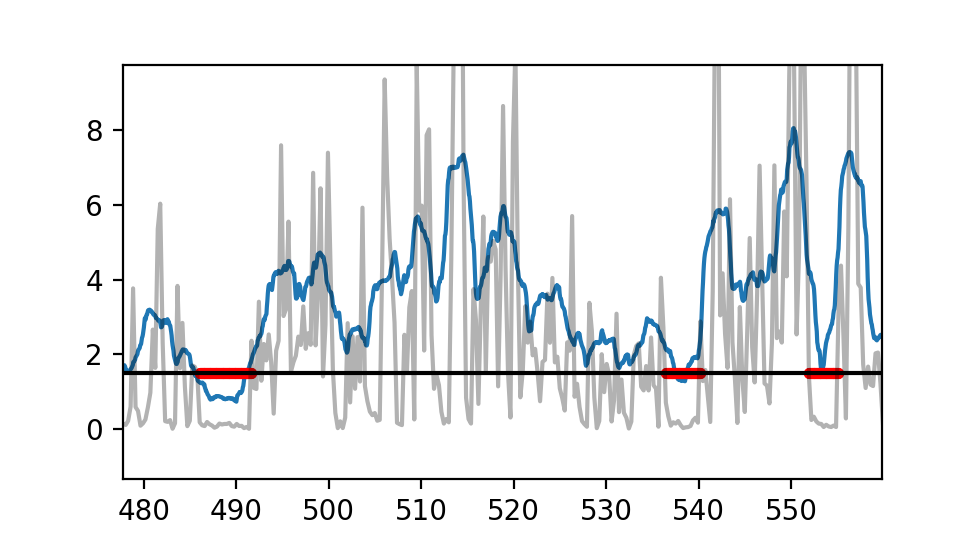

In [93]:
# Check freezing overlaid on velocity data here.
dir_use = pf.get_dir(mouse, arena, day)
freeze_check, vel_check, time_check = erp.detect_freezing(dir_use, arena=arena, return_time=True)  # Downsampled
speed3, pos3, t3, sr = pf.get_speed(dir_use)  # direct from behavioral file

%matplotlib notebook
fig2, ax2 = plt.subplots()
fig2.set_size_inches([3, 2])

# So velocity is off by 1 freeze-frame + 2 plexon frames - this is ok/desired - getting sampling rate
ax2.plot(time_check[0] + np.arange(len(PF.speed_sm))/20, PF.speed_sm)  
ax2.plot(time_check[0] + freeze_ind/20, np.ones_like(freeze_ind)*1.5, 'r.')   # seem to be shifted by one behavioral frame forward...shift back!
ax2.plot(time_check[0:-1], vel_check, color=[0,0,0,0.3])  # This seems to be shifted by video_t[0]. So need to add or subtract start time somewhere!!!
ax2.axhline(1.5, color=[0, 0, 0])
# ax2.plot(t3[0:-1], speed3/10, color=[0,0,0,0.3])

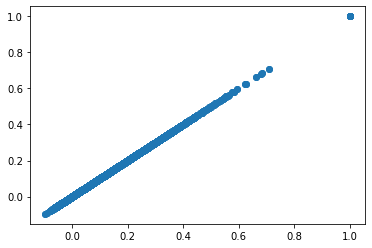

In [7]:
# Is the covariance matrix being calculated correctly? yes
cov_matz2 = np.matmul(PSAbinz, PSAbinz.T)/PSAbinz.shape[1]
fig, ax = plt.subplots()
ax.scatter(cov_matz.reshape(-1), cov_matz2.reshape(-1))

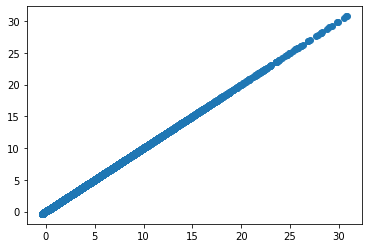

In [8]:
# Is z-scoring being done properly? Yup. (Well nope, shouldn't it have mean = 0 and std = 1 after transforming?)
# So our procedure violates the assumption of Lopes-dos-Santos (2013) and we won't be able to use their equation for
# the Marcenko-Pastur distribution to figure out the number of assemblies we detect. 
# But, we might be able to use their surrogate distribution method ...
nneurons, ncols = PSAbin.shape
psa_mean_mat = np.matlib.repmat(PSAbin.mean(axis=1).reshape(nneurons, -1), 1, ncols)
psa_std_mat = np.matlib.repmat(PSAbin.std(axis=1).reshape(nneurons, -1), 1, ncols)
PSAz_direct = (PSAbin - psa_mean_mat) / psa_std_mat
fig, ax = plt.subplots()
ax.scatter(PSAbinz.reshape(-1), PSAz_direct.reshape(-1))

[7.45739274 7.1253537  6.45189402 6.01113406 5.77524248 5.44194053
 5.1026659  4.93734336 4.63645815 4.50975279 4.29522344 4.2136809
 4.15956716 3.97783977 3.78686054 3.70187512 3.63402737 3.59610391
 3.54006879 3.46361688 3.40612737 3.3016245  3.26636011 3.17926787
 3.15234543 3.13999047 3.12422996 3.05446307 2.99852168 2.96357471
 2.93527427 2.90348501 2.87564058 2.8502133  2.79587507 2.77690356
 2.76354928 2.74082939 2.72592647 2.69443066 2.66923467 2.64593577
 2.6248115  2.5878461  2.56561394 2.53954328 2.51499423 2.49530471
 2.45648929 2.42716127]


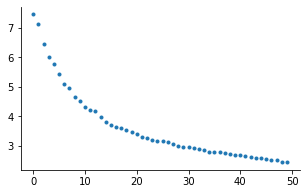

In [14]:
# Maybe the singular_values_ attribute is what I am looking for? The .explained_variance_ attribute seems to be 
# consist of super small values depsite pulling out some good looking assemblies ...
fig, ax = plt.subplots()
fig.set_size_inches([5,3])

PCtransformer2 = PCA(n_components=50, random_state=0)
PCAcov_trans = PCtransformer2.fit_transform(cov_matz)
ax.plot(PCtransformer2.singular_values_, '.')
sns.despine(ax=ax)

print(PCtransformer2.singular_values_)


Sanity check mean diff b/w = 0.003184163024805425


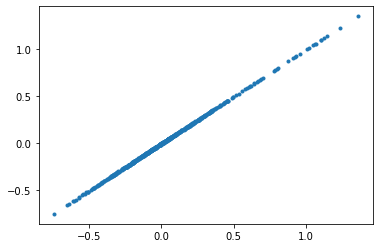

In [27]:
# Sanity check - make sure .explained_variance_ actually equals the eigenvalue and the first component 
# actually equals an eigenvector!
component = 0
left_side = np.matmul(cov_matz,PCtransformer2.components_[component])
right_side = PCtransformer2.singular_values_[component]*PCtransformer2.components_[component]

fig_eig, ax_eig = plt.subplots()
ax_eig.plot(left_side, right_side, '.')

print('Sanity check mean diff b/w = ' + str(np.mean(left_side - right_side)))

Ok!!! So the take home is that the .singular_values_ field of the PCA transform is what represents the eigenvalue, NOT the .explained_variance_

# Ok, now project the covariance matrix onto the first N principal components!

In [28]:
# First check total # of expected assemblies from Lopes-dos-Santos (2013) and Marcenko-Pastur distribution.
# Also citing van de Ven et al. (2016)
q = PSAbin.shape[1]/PSAbin.shape[0]
rho2 = 1
lambdamin = rho2*np.square(1 - np.sqrt(1/q))
lambdamax = rho2*np.square(1 + np.sqrt(1/q))
# pMP = q/(2.np.pi*rho2)*np.sqrt()
print(f'\u03BBmax =  {lambdamax:0.3g}, \u03BBmin =  {lambdamin:0.3g}')

λmax =  2.92, λmin =  0.0844


In [34]:
PCtransformer2.components_.shape

(50, 604)

In [74]:
# Ok, this *should* be the van de Ven method in full here!!!

nA = np.max(np.where(PCtransformer2.singular_values_ > lambdamax)[0])
psign = PCtransformer2.components_[0:nA].T
zproj = np.matmul(psign.T, PSAbin)
cov_zproj = np.cov(zproj)

transformer3 = FastICA(random_state=0, whiten=False, max_iter=10000)
w_mat = transformer3.fit_transform(cov_zproj)  # I think this is correct! When I run it on the full zproj I get lots of errors...
v = np.matmul(psign, w_mat)

/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


In [87]:
PSAbinz.shape

(604, 1200)

<IPython.core.display.Javascript object>


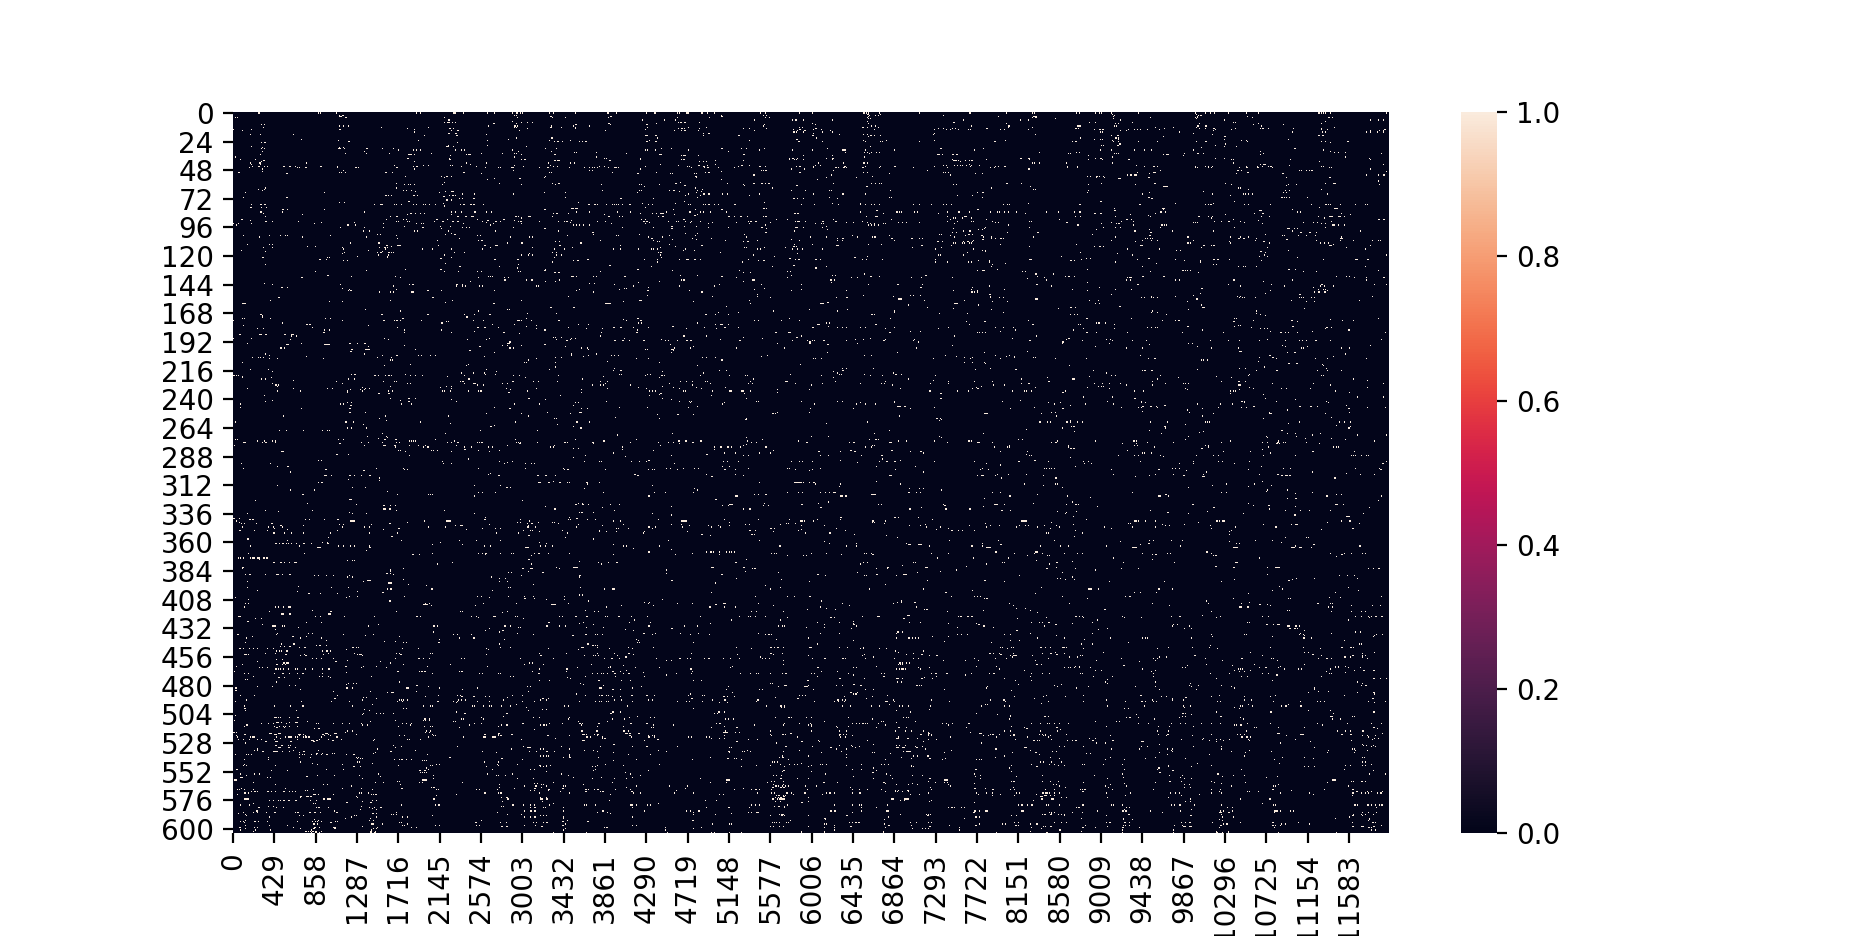

<AxesSubplot:>

In [91]:
%matplotlib notebook
isort = np.argsort(v[:,1])
figf, axf = plt.subplots()
sns.heatmap(PSAbool[isort,:], ax=axf)

In [116]:
ax[0][0].tick_params

<bound method _AxesBase.tick_params of <AxesSubplot:title={'center':'Cell 329 wt=-0.51'}>>

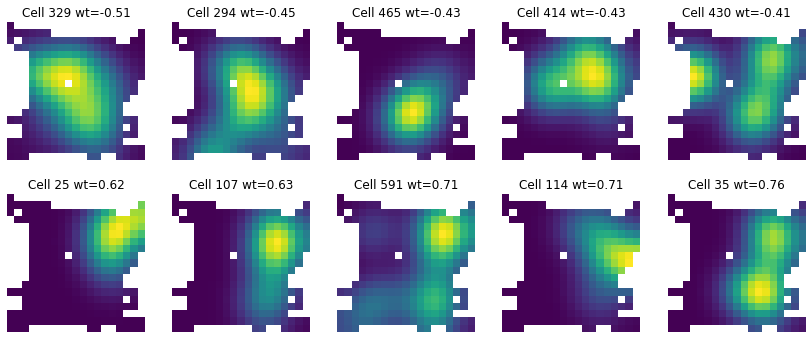

In [121]:
%matplotlib inline
# plot place fields of top and bottom assembly members!
assemb_no = 7

fig, ax = plt.subplots(2,5)
fig.set_size_inches([14.3, 5.8])

# Grab top and bottom five pf weights
isort = np.argsort(v[:,assemb_no])
inds_plot = []
inds_plot.append(isort[:5])
inds_plot.append(isort[-5:])
inds_plot = np.asarray(inds_plot)

for a, ind in zip(ax.reshape(-1), inds_plot.reshape(-1)):
    a.imshow(PF.tmap_sm[ind])
    a.set_title(f'Cell {ind} wt={v[ind, assemb_no]:0.2g}')
    a.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

sns.despine(fig=fig, bottom=True, left=True)

In [102]:
fig.get_size_inches()

array([9.29, 2.83])

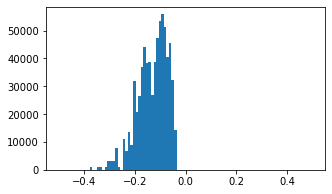

In [46]:
# How does z-scoring actually look? this seems to be the issue - our data is not actually normally distributed, 
# even after z-scoring.
fig, ax = plt.subplots()
fig.set_size_inches([5,3])
_ = ax.hist(PSAbinz.reshape(-1), np.linspace(-0.5, 0.5, 100))

In [107]:
ct_df.columns != 'cell'

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [120]:
# Create array of activations
activation = []
for ica_weight in ct_df.values.swapaxes(0,1):
     activation.append(np.matmul(ica_weight, PF.PSAbool_align))
act_array = np.asarray(activation[1:])

In [122]:
# Now correlate with speed and multiply by freezing
freeze_proj, speed_corr = [], []
for act in act_array:
    act = np.asarray(act, dtype=float)
    corr_mat = np.corrcoef(np.stack((act, PF.speed_sm), axis=1).T)
    speed_corr.append(corr_mat[0,1])
    freeze_proj.append((act*freeze_bool).sum())

freeze_proj = np.asarray(freeze_proj)
speed_corr = np.asarray(speed_corr)

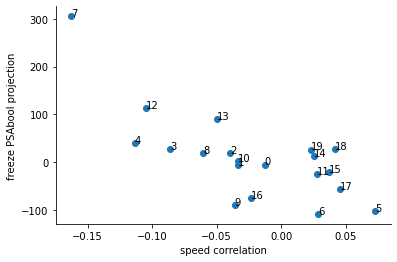

In [123]:
# Plot it out - the freeze projection should stand out!!!
fig, ax = plt.subplots()
s = ax.scatter(speed_corr, freeze_proj)
ax.set_xlabel('speed correlation')
ax.set_ylabel('freeze PSAbool projection')
for idc, (x, y) in enumerate(zip(speed_corr, freeze_proj)):
    ax.text(x, y, str(idc))
sns.despine(ax=ax)

ica_plot = 7


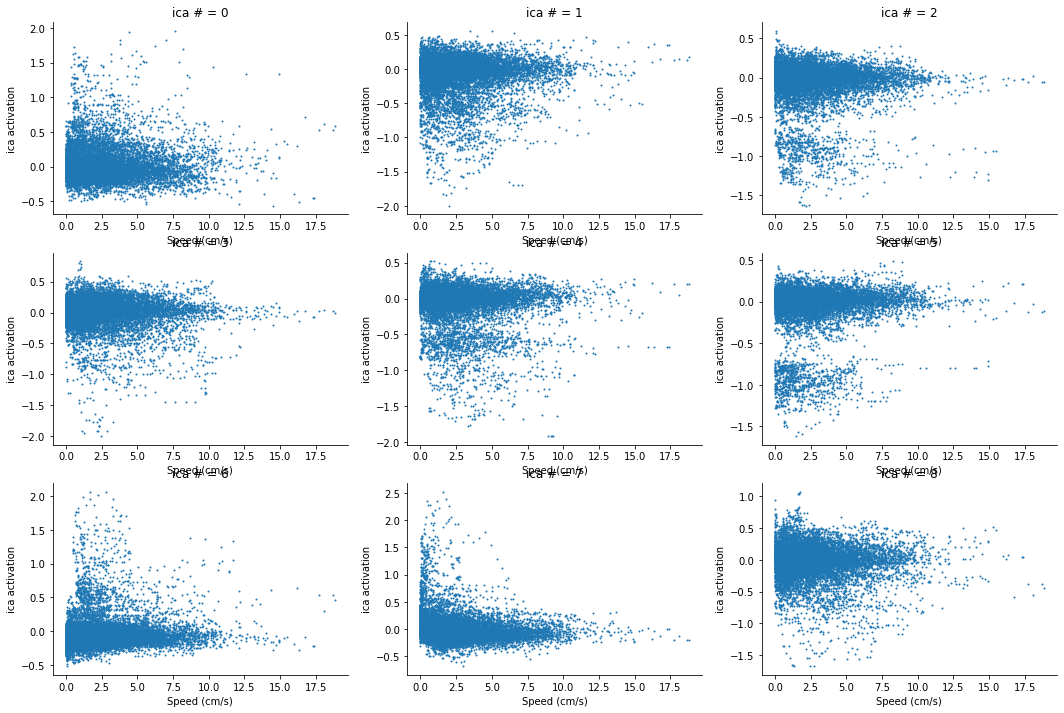

In [124]:
# plot out what the "speed correlation" actually looks like - seems to be more of a bimodality than anything else, 
# so while some might be actually related to freezing others might not be. Better would be to
# a) calculate cross correlation with freezing! Look for ensembles whose peak activity peaks just around freeze onset,
# b) calculate projection on freeze start boolean, e.g. the boolean you use for calculating peri-freeze onset rasters
# c) don't neglect ensembles that might be super active during freezing in general though!

%matplotlib inline
# Identify the ica that correlates best with freezing and plot it below
ica_plot = np.where(speed_corr < -0.15)[0][0]
print(f'ica_plot = {ica_plot}')
figc, axc = plt.subplots(3,3)
figc.set_size_inches([18, 12])
for ida, (act, a) in enumerate(zip(act_array[0:10], axc.reshape(-1))):
    a.scatter( PF.speed_sm, act, s=1)
    a.set_title(f'ica # = {ida}')
    a.set_xlabel('Speed (cm/s)')
    a.set_ylabel('ica activation')
sns.despine(fig=figc)

<IPython.core.display.Javascript object>


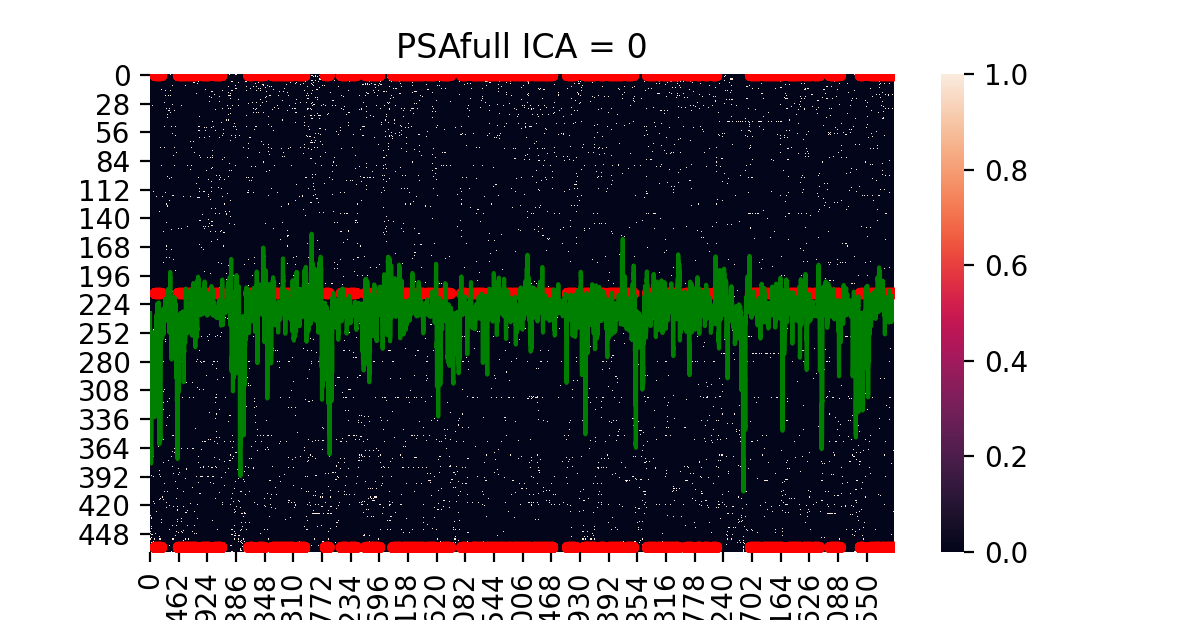

In [30]:
%matplotlib notebook
ica_plot = 0
activation = np.matmul(ct_df[ica_plot], PF.PSAbool_align)  # Project ICA weights onto PSAbool to get assembly activation
isort = ct_df[ica_plot].argsort()
PSAsort_bin = PSAbin[isort[::-1]]
PSAsort = PF.PSAbool_align[isort[::-1]]
fig, ax = plt.subplots()
fig.set_size_inches([6, 3.1])
sns.heatmap(PSAsort, ax=ax)
ax.set_title('PSAfull ICA = ' + str(ica_plot))
# sns.heatmap(PSAsort_bin, ax=ax[1])
# ax[1].set_title('PSAbin ICA = ' + str(ica_plot))

# plot freezing times
# Need to plot versus times here! Not just indices! or maybe it is ok since I have already aligned. Would be nice to overlay velocity as a check!
ax.plot(freeze_ind, np.ones_like(freeze_ind), 'r.')
ax.plot(freeze_ind, np.ones_like(freeze_ind)*(PF.PSAbool_align.shape[0]/2-20), 'r.')
ax.plot(freeze_ind, np.ones_like(freeze_ind)*(PF.PSAbool_align.shape[0]-5), 'r.')
ax.plot(-activation*100 + PF.PSAbool_align.shape[0]/2, 'g-')
# ax.plot(-PF.speed_sm*10 + PF.PSAbool_align.shape[0]/2, 'b-')


# After that, use the method from Lopes-dos-Santos 2013 to determine the # of assemblies

In [39]:
# NRK todo: plot the same way as single-cells - PSTH of activations for each ensemble.
# Grrr, this might not work as PSAbool_align might start at the onset of movement, but I'm using times below. Make sure 
# aligned properly!

# Get assembly activations\
activation = []
for ica in range(nICs):
    activation.append(np.matmul(ct_df[ica], PF.PSAbool_align))
activation = np.asarray(activation)

# Create motion tuning class and identify freezing starts
md = fa.MotionTuning(mouse, arena, day)
freeze_starts = md.select_events('freeze_onset')

No tunings found for this session - run .get_tuning_sig() and .save_sig_tuning()


<IPython.core.display.Javascript object>


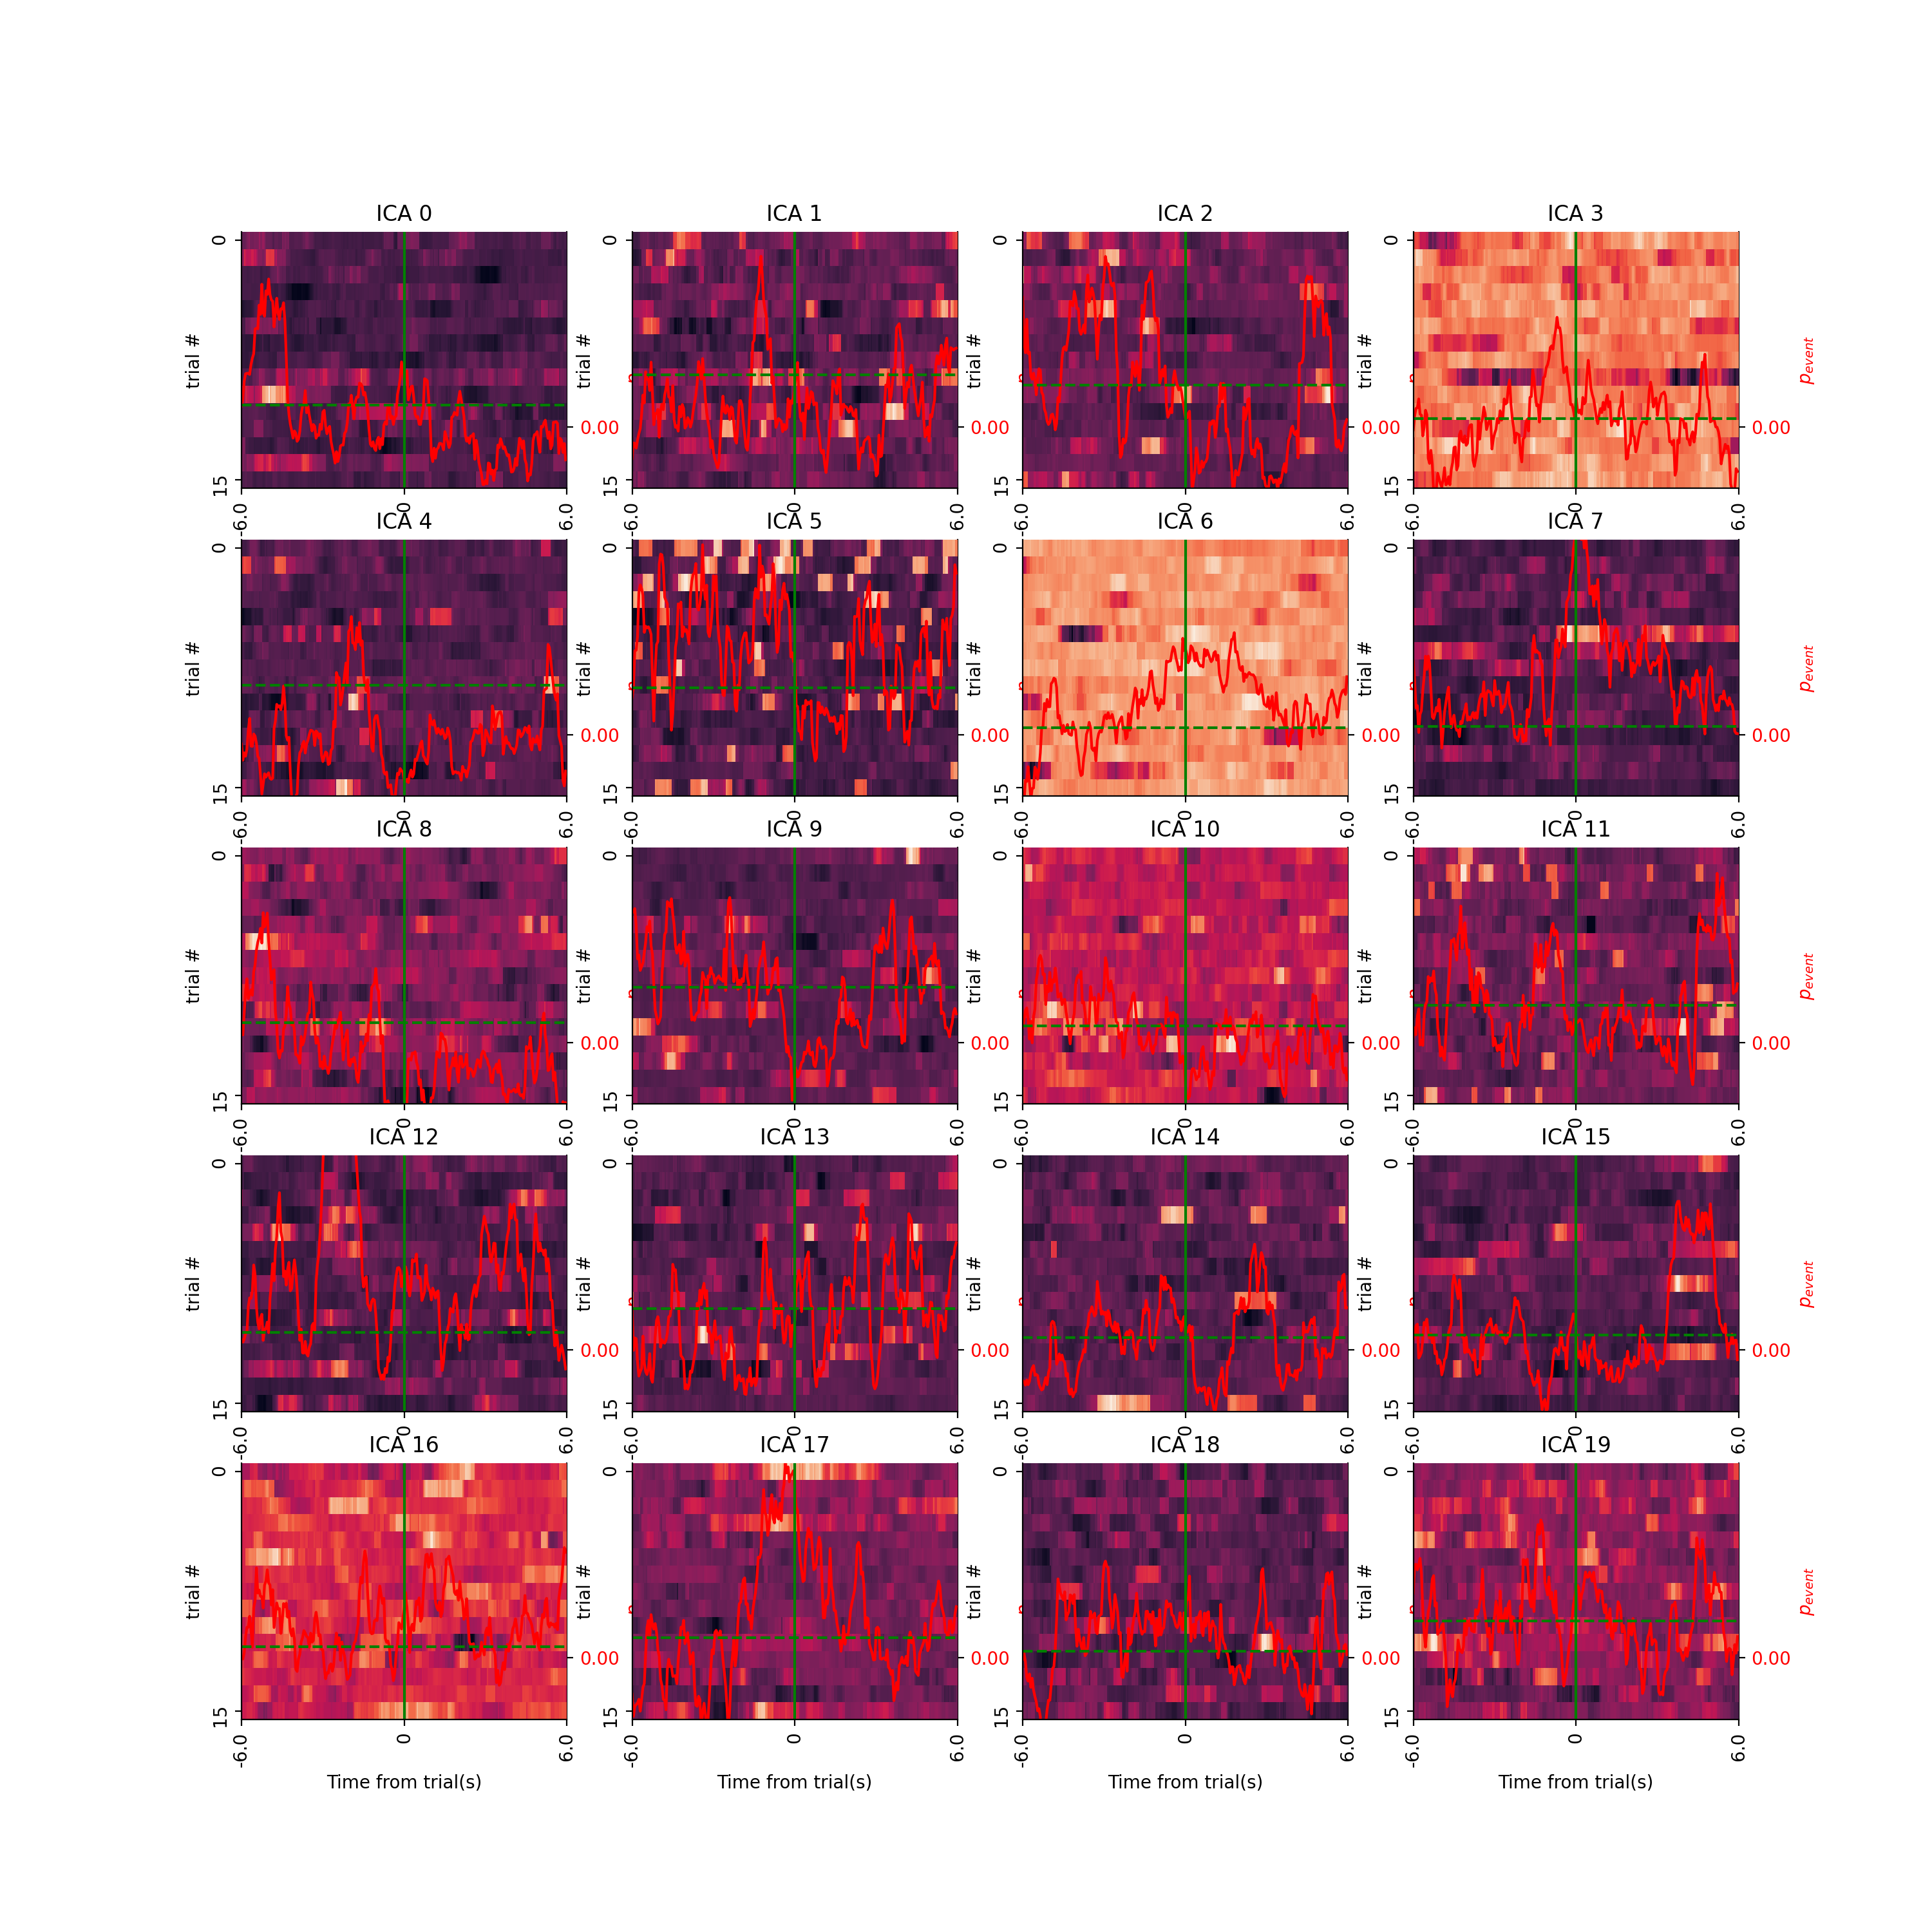

In [117]:
# Loop through and plot each ICAs raster
ncols = 4
nrows = np.ceil(nICs/ncols).astype(int)
fig, ax = plt.subplots(nrows, ncols)
fig.set_size_inches([3*nrows, 15])

ntrials = freeze_starts.shape[0]
buffer = 6
for ida, (a, act) in enumerate(zip(ax.reshape(-1), activation)):
    # Assemble raster for assembly and calculate mean activation
    assemb_raster = fa.get_PE_raster(act, event_starts=freeze_starts, buffer_sec=[buffer, buffer], 
                                     sr_image=PF.sr_image)
    act_mean = act.mean()
    # Hack to switch up signs - necessary?
    if act_mean < 0:
        assemb_raster = assemb_raster * -1
        act_mean = act_mean * -1
  
    fa.plot_raster(assemb_raster, cell_id=ida, bs_rate=act_mean, sr_image=PF.sr_image, ax=a,
                  y2scale=0.35, y2zero=ntrials/5, cmap='rocket')
    a.set_title(f'ICA {ida}')
#     # plot raster
#     nevents, nframes = assemb_raster.shape
#     sns.heatmap(assemb_raster, ax=a)
#     a.axhline(act.mean(), color='g')
    
#     # label everything
#     a.set_xticks([0, nframes / 2, nframes])
#     a.set_xticklabels([str(-buffer), '0', str(buffer)])'
#     a.set_xlabel('Time from freeze (s)')
    
#     a.set_yticks([0.5, nevents - 0.5])
#     a.set_yticklabels(['0', str(nevents)])
#     a.set_ylabel(events + ' #')
    
#     a.set_title(f'ICA {a}')

In [187]:
pe_tuning.mean()

-0.04736338114661549

In [54]:
# Next = calculate tuning same way as for individual cells and ID freezing assembly!!! 
# Cross check with freezing cells!
# Then, plot out occupancy map of activation!!! Are these ICAs place cell assemblies also? 
ic_use = 7
buffer = 2
nperm = 1000
alpha = 0.01
pe_raster = fa.get_PE_raster(activation[ic_use], event_starts=freeze_starts, buffer_sec=[buffer, buffer], 
                                     sr_image=PF.sr_image)
perm_rasters = fa.shuffle_raster(activation[ic_use], freeze_starts, buffer_sec=[buffer, buffer], 
                                 sr_image=PF.sr_image, nperm=nperm)

pe_tuning = fa.gen_motion_tuning_curve(pe_raster)
perm_tuning = np.asarray([fa.gen_motion_tuning_curve(perm_raster) for perm_raster in perm_rasters])

# Hack to switch sign for negative assembly weights
if pe_tuning.mean() < 0:
    pe_tuning = pe_tuning * -1
    perm_tuning = perm_tuning * -1
    
pval = (pe_tuning < perm_tuning).sum(axis=0) / nperm
np.sum(pval < alpha)

25

In [7]:
def remake_occmap(xBin, yBin, runoccmap, good_bool:None or np.ndarray or list = None):
    """Fix occmap generated by Placefields.placefields() prior to 11/29/2021 - bug results in occmap = runoccmap"""
    ny, nx = runoccmap.shape
    if isinstance(good_bool, (np.ndarray, list)):
        x_use, y_use = xBin[good_bool], yBin[good_bool]
    elif good_bool is None:
        x_use, y_use = xBin, yBin
    xEdges, yEdges = np.arange(0, nx + 1), np.arange(0, ny + 1)
    occmap, _, _ = np.histogram2d(x_use, y_use, bins=[xEdges+0.5, yEdges+0.5])
    occmap = np.rot90(occmap, 1)
    return occmap
    

<IPython.core.display.Javascript object>


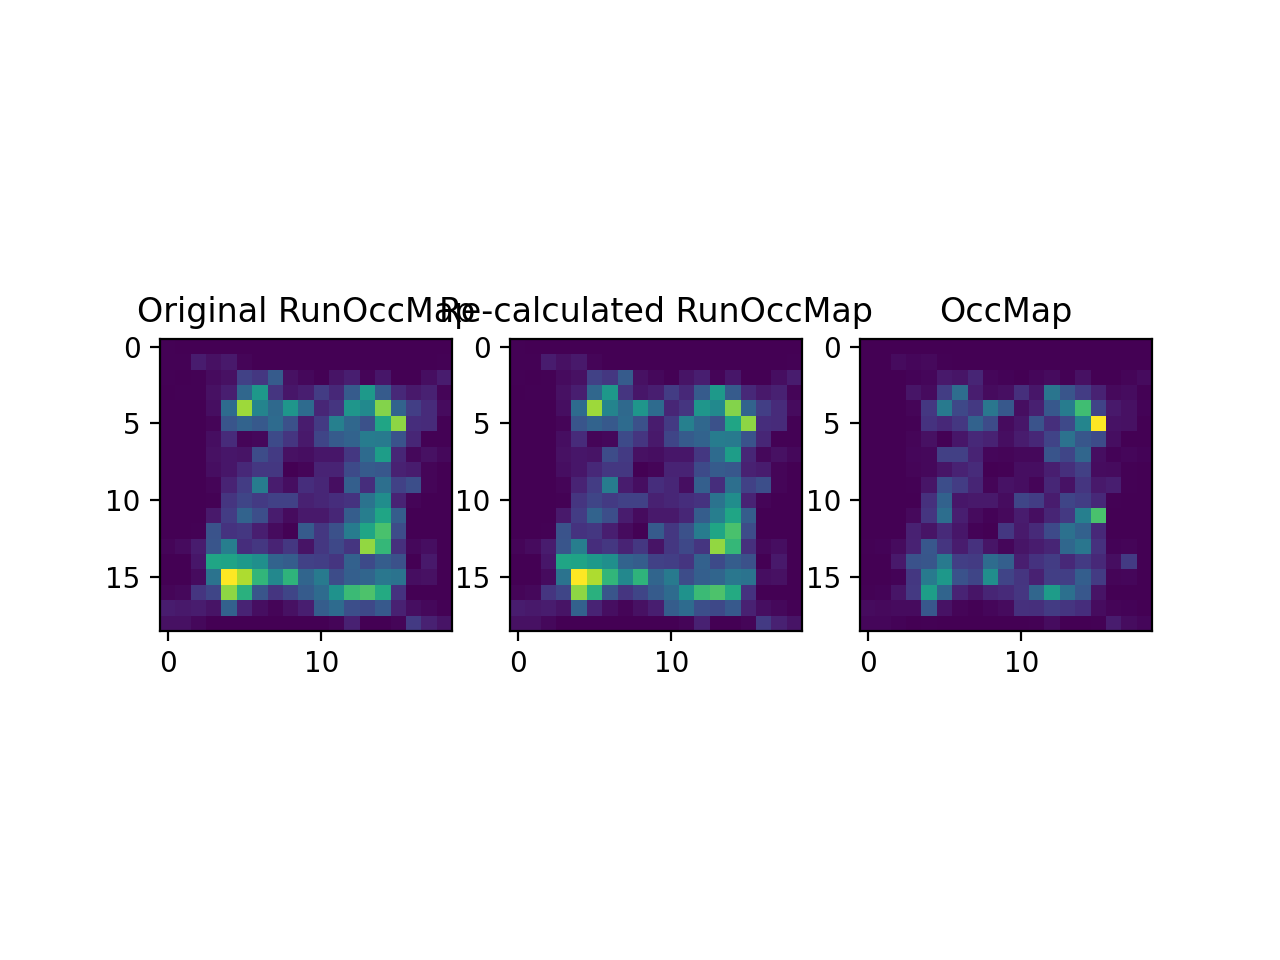

Text(0.5, 1.0, 'OccMap')

In [40]:
runoccmap = remake_occmap(PF.xBin, PF.yBin, PF.runoccmap, good_bool=PF.isrunning)
occmap = remake_occmap(PF.xBin, PF.yBin, PF.runoccmap)
fig, ax = plt.subplots(1,3)
ax[0].imshow(PF.runoccmap)
ax[0].set_title('Original RunOccMap')
ax[1].imshow(runoccmap)
ax[1].set_title('Re-calculated RunOccMap')
ax[2].imshow(occmap)
ax[2].set_title('OccMap')


<IPython.core.display.Javascript object>


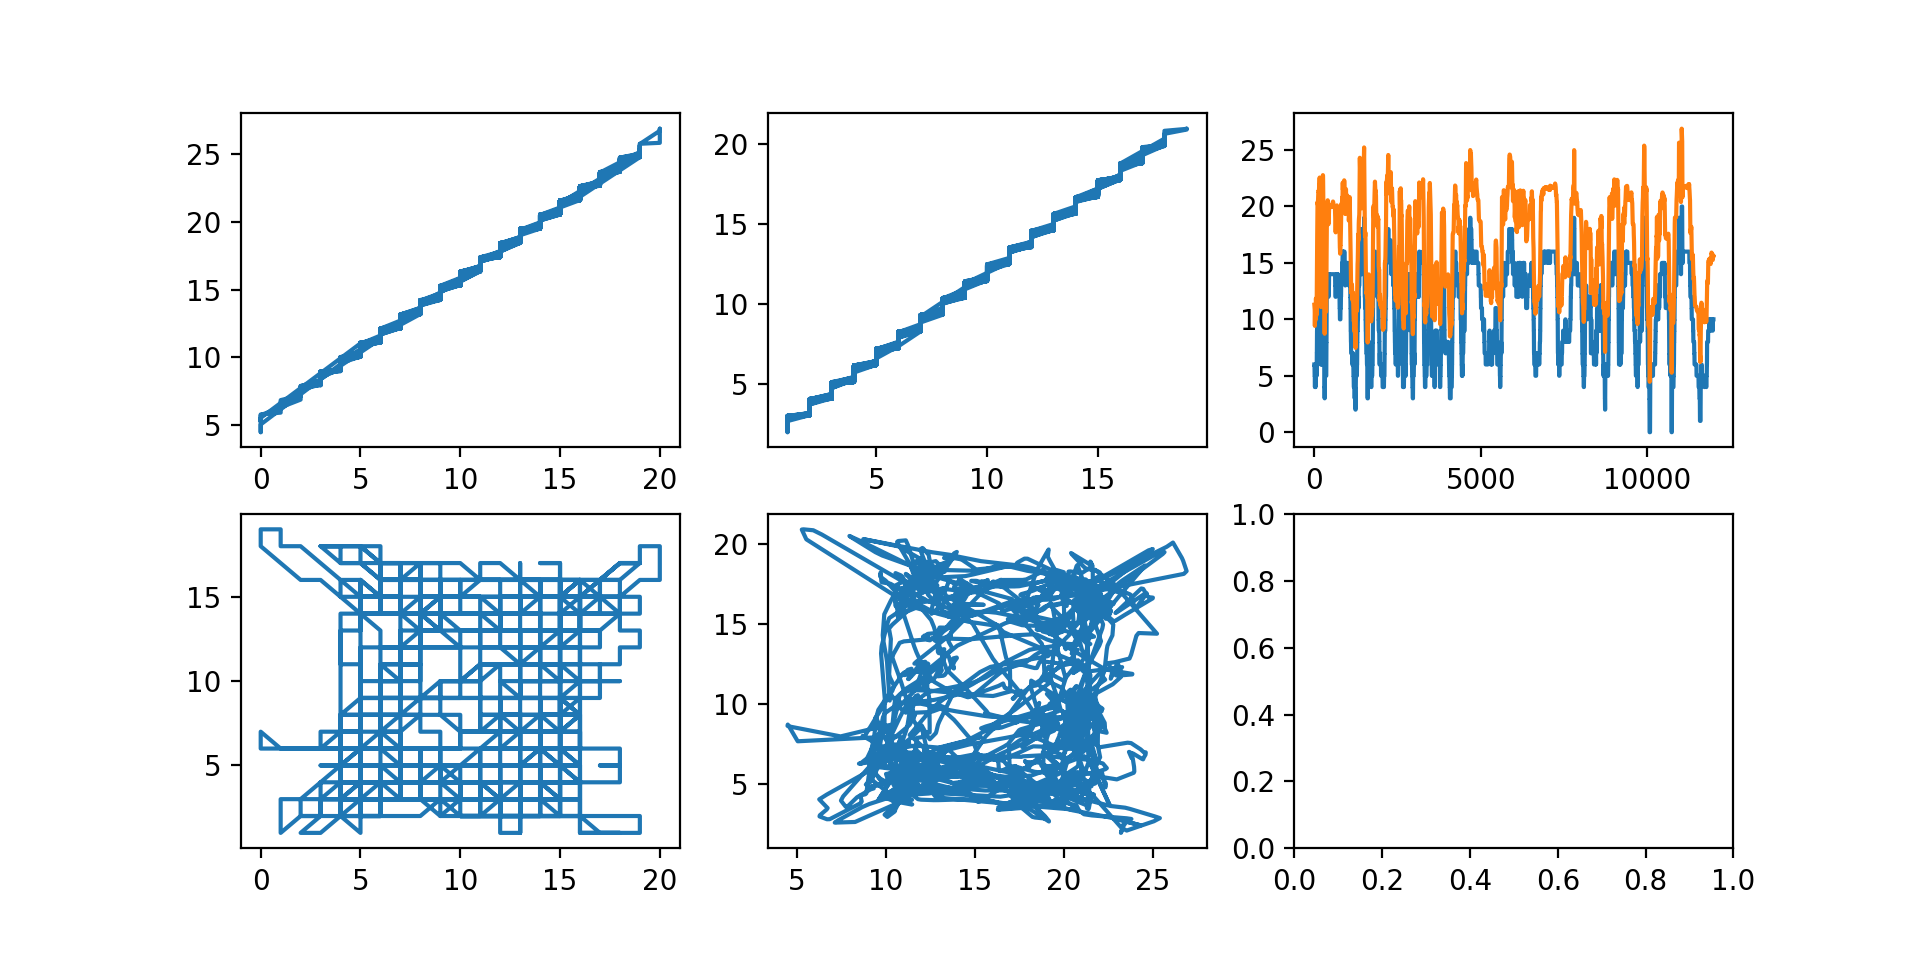

In [64]:
# Sanity check that xBin and yBin are representing position properly - they are!
fig, ax = plt.subplots(2,3)
ax[0][0].plot(PF.xBin, PF.pos_align[0,:])
ax[0][1].plot(PF.yBin, PF.pos_align[1,:])
ax[1][0].plot(PF.xBin, PF.yBin)
ax[1][1].plot(PF.pos_align[0,:], PF.pos_align[1,:])

ax[0][2].plot(PF.xBin)
ax[0][2].plot(PF.pos_align[0,:])

In [75]:
# Compare to occmap calculated using xBin to calculate!!!
ny, nx = PF.runoccmap.shape
xEdges, yEdges = np.arange(0, nx + 1), np.arange(0, ny + 1)
occ_map_check = np.zeros_like(PF.runoccmap)
# Loop through each bin and add up assembly values in that bin
for xb in range(nx):
    for yb in range(ny):
        in_bin_bool = np.bitwise_and((PF.xBin - 1) == xb, (PF.yBin - 1) == yb)
        occ_map_check[xb, yb] = in_bin_bool.sum()

occ_map_check = np.rot90(occ_map_check, 1)

In [78]:
(occ_map_check - occmap).reshape(-1).sum()

0.0

<IPython.core.display.Javascript object>


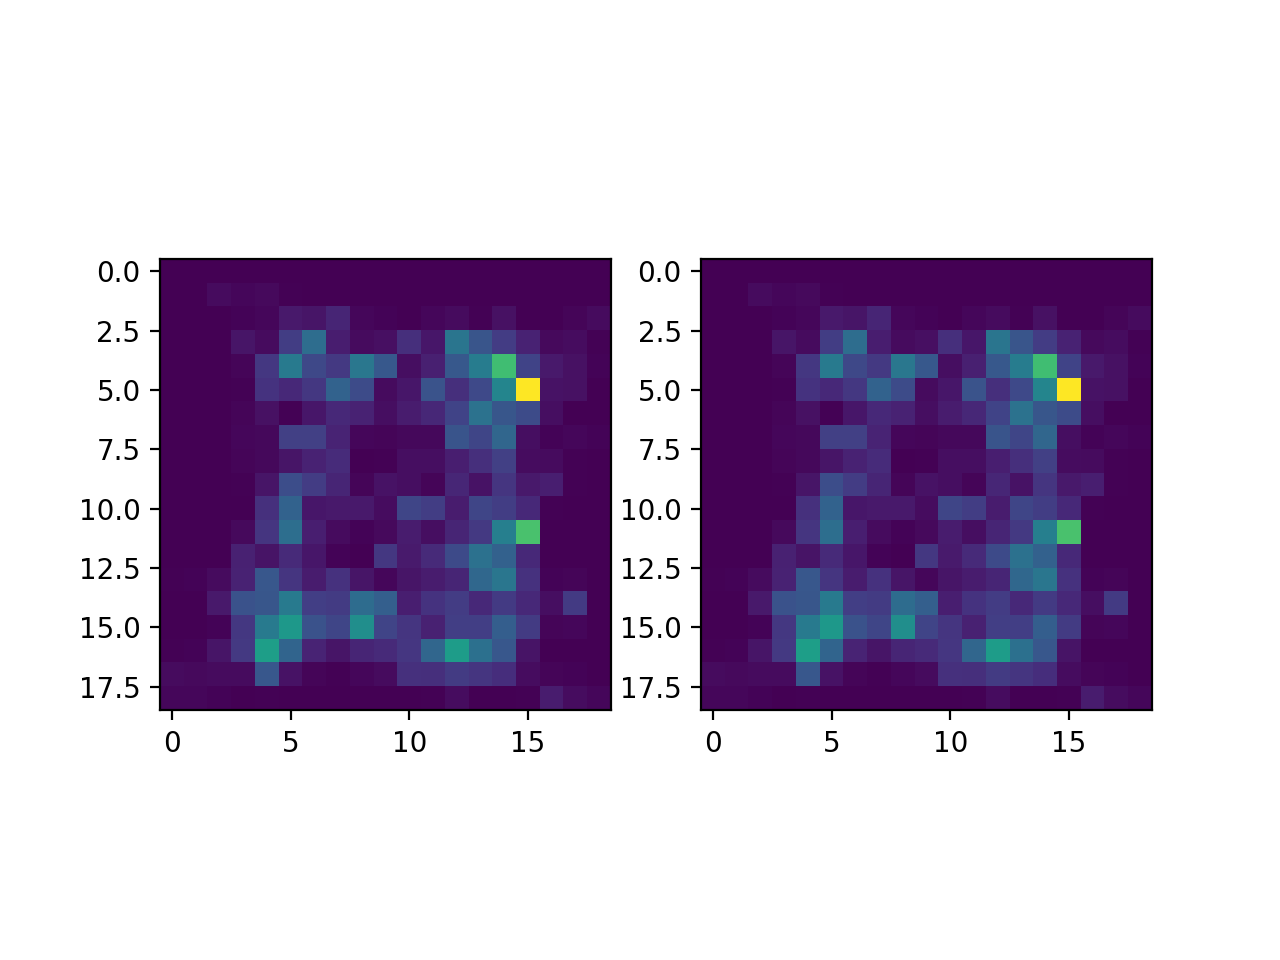

In [76]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(occmap)
ax[1].imshow(occ_map_check)

In [68]:
occmap[0,0]

1.0

In [71]:
PF.xBin.shape

(11991,)

In [70]:
occ_map_check.reshape(-1).sum()

11939.0

In [69]:
occmap.reshape(-1).sum()

11951.0

In [15]:
print(np.unique(PF.xBin))
np.unique(PF.yBin)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19])

In [13]:
PF.runoccmap.shape

(19, 19)

In [35]:
print('xmin = ' + str(PF.pos_align[0,:].min()) + ' xmax = ' + str(PF.pos_align[0,:].max()))
print('ymin = ' + str(PF.pos_align[1,:].min()) + ' ymax = ' + str(PF.pos_align[1,:].max()))

xmin = 4.467337801233929 xmax = 26.895735935465414
ymin = 1.9587109982808462 ymax = 20.948493561638703


In [32]:
PF.yEdges

array([ 1.938     ,  2.99063158,  4.04326316,  5.09589474,  6.14852632,
        7.20115789,  8.25378947,  9.30642105, 10.35905263, 11.41168421,
       12.46431579, 13.51694737, 14.56957895, 15.62221053, 16.67484211,
       17.72747368, 18.78010526, 19.83273684, 20.88536842, 21.938     ])

In [30]:
PF.xEdges

array([ 5.814     ,  6.86663158,  7.91926316,  8.97189474, 10.02452632,
       11.07715789, 12.12978947, 13.18242105, 14.23505263, 15.28768421,
       16.34031579, 17.39294737, 18.44557895, 19.49821053, 20.55084211,
       21.60347368, 22.65610526, 23.70873684, 24.76136842, 25.814     ])

In [173]:
run_bool = PF.isrunning
nx, ny = PF.runoccmap.shape
if run_bool is not None:
    x_use, y_use = PF.xBin[run_bool], PF.yBin[run_bool]
elif run_bool is None:
    x_use, y_use = PF.xBin, PF.yBin
xEdges, yEdges = np.arange(0, nx + 1), np.arange(0, ny + 1)
map2, _, _ = np.histogram2d(x_use, y_use, bins=[xEdges+0.5, yEdges+0.5])
map2 = np.rot90(map2, 1)
print(f'nbins diff b/w orig and re-calculated runoccmap = {(map2-PF.runoccmap).reshape(-1).sum()}')

nbins diff b/w orig and re-calculated runoccmap = 0.0


In [ ]:
# NRK todos:
# 1) get assembly spatial plots working!  Should see place field like things going on! Compare to PFs of strongest
# cells in assembly as sanity check - plot IC place field + top 5 place fields in same figure?

# 2) quantify # freezing ensembles each day.  Figure out good criteria?!?

# 3) track across days!

<IPython.core.display.Javascript object>


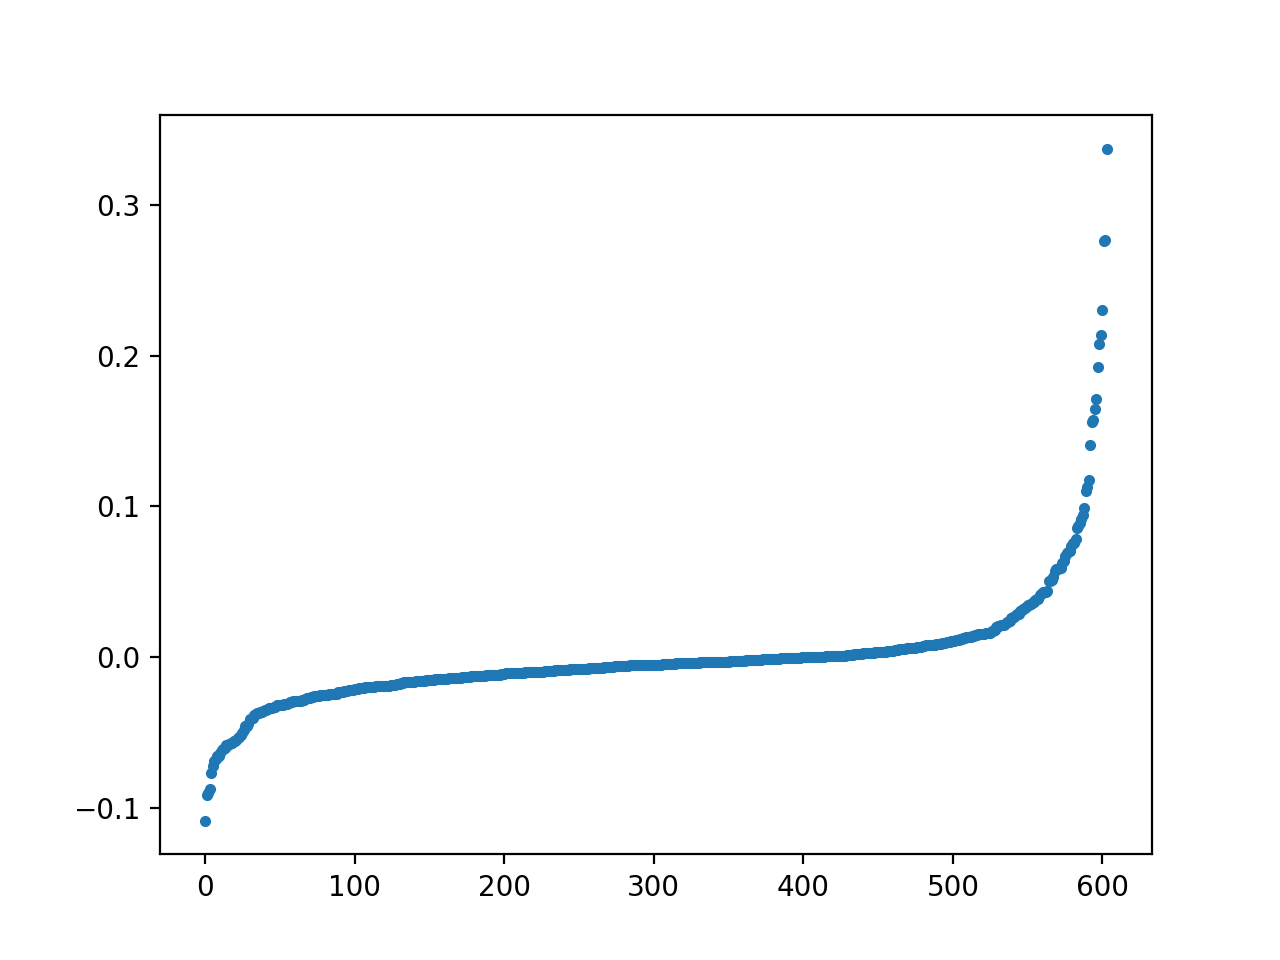

n > 0: 204
n < 0: 400


In [115]:
fig, ax = plt.subplots()
ax.plot(np.sort(ct_df.iloc[:, 1]), '.')
print('n > 0: ' + str(np.sum(np.sort(ct_df.iloc[:, 1]) > 0)))
print('n < 0: ' + str(np.sum(np.sort(ct_df.iloc[:, 1]) < 0)))

In [92]:
_, freeze_bool = fa.get_freeze_bool(mouse, arena, day)
freeze_bool.shape

(11991,)

<IPython.core.display.Javascript object>


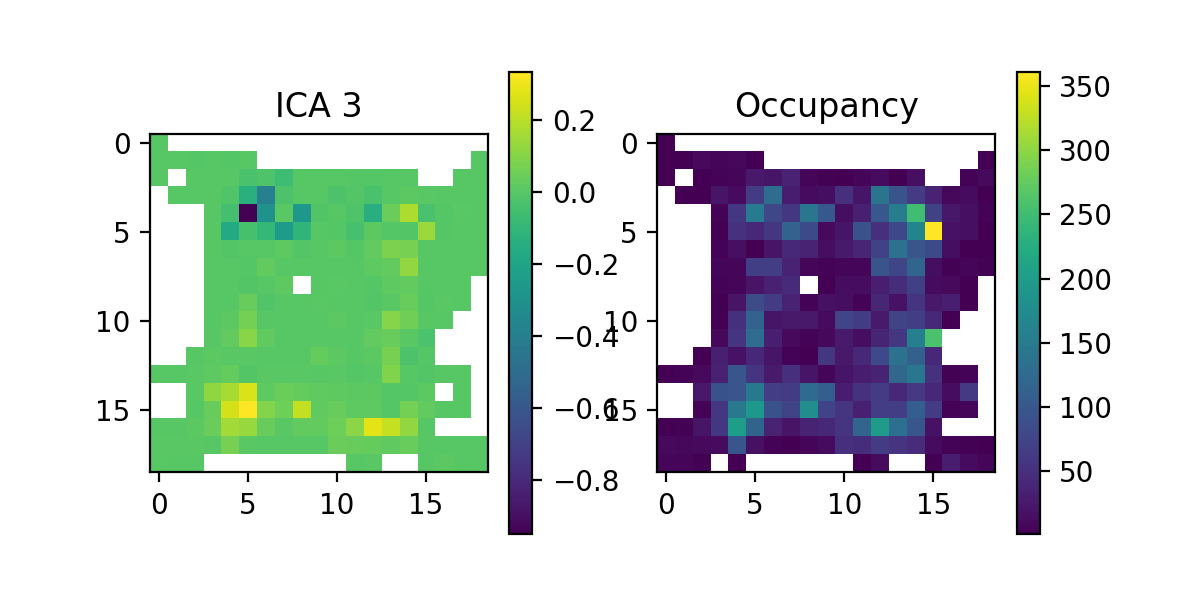

In [97]:
%matplotlib notebook
# ok, so #6 and #16 from Marble07 Shock Day 2 seem to stand out as clear freezing ensembles.  Plot out place fields
# and/or occupation map of activity for this mouse.
# Weird plotting bug with pf.imshow_nan
ic_use = 3
map_use = 'occ'  # 'occ' or 'run'

# Bug below - runoccmap is occmap due to old bug in Placefields.placefields(). So I need to reconstruct it!
if map_use == 'occ':
    occ_map_nan = remake_occmap(PF.xBin, PF.yBin, PF.runoccmap)
elif map_use == 'run':
    occ_map_nan = PF.runoccmap.copy()
occ_map_nan[occ_map_nan == 0] = np.nan


assemb_pf = np.zeros_like(PF.occmap)
occ_map_check = np.zeros_like(PF.occmap)
ny, nx = assemb_pf.shape

# Loop through each bin and add up assembly values in that bin
for xb in range(nx):
    for yb in range(ny):
        in_bin_bool = np.bitwise_and((PF.xBin - 1) == xb, (PF.yBin - 1) == yb)
        assemb_pf[xb, yb] = activation[ic_use][in_bin_bool].sum()
        occ_map_check[xb, yb] = in_bin_bool.sum()

assemb_pf = np.rot90(assemb_pf, 1)
occ_map_check = np.rot90(occ_map_check, 1)
occ_map_check[occ_map_check == 0] = np.nan
occmap[occmap == 0] = np.nan

assemb_pf = assemb_pf*PF.occmap/np.nansum(PF.occmap.reshape(-1))
assemb_pf[np.bitwise_or(PF.occmap == 0, np.isnan(PF.occmap))] = np.nan

fig, ax = plt.subplots(1, 2)
fig.set_size_inches((6, 3))
pos = ax[0].imshow(assemb_pf)
ax[0].set_title(f'ICA {ic_use}')
fig.colorbar(pos, ax=ax[0])
pos2 = ax[1].imshow(occmap)
ax[1].set_title('Occupancy')
fig.colorbar(pos2, ax=ax[1])

In [54]:
occ_map_check

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   6.,   6.,   3.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          0.,   2.,  12.,   0.,   0.,   2.,  28.,  12.],
       [  0.,  10.,   9.,  10.,  11.,  98.,  17.,   5.,   2.,   6.,  11.,
         50.,  48.,  63.,  55.,  47.,  12.,   5.,   3.],
       [  0.,   2.,   3.,  21.,  60., 202., 117.,  36.,  20.,  37.,  43.,
         57., 119., 200., 133.,  98.,  19.,   0.,   0.],
       [  0.,   0.,   0.,   4.,  58., 147., 193.,  91.,  75., 178.,  74.,
         56.,  33.,  67.,  67., 108.,  63.,   5.,   7.],
       [  0.,   0.,   0.,  25.,  91.,  96., 147.,  67.,  63., 127., 109.,
         30.,  53.,  64.,  41.,  61.,  42.,  13.,  62.],
       [  3.,   2.,   4.,  10.,  34.,  98.,  56.,  27.,  51.,  21.,   7.,
         21.,  28.,  37., 120., 142.,  52.,   3.,   5.],
       [ 11.,   0.,   0.,   1.,  33.,  19.,  43.,  22.,   4.,   1.,  59.,
         

In [52]:
occ_map_nan

array([[  1.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan],
       [  1.,   1.,  10.,   6.,   9.,   2.,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,   1.],
       [  1.,  nan,   1.,   4.,   6.,  25.,  21.,  37.,   6.,   3.,   1.,
          7.,  11.,   2.,  16.,  nan,  nan,   5.,  10.],
       [ nan,   1.,   1.,  21.,  11.,  65., 129.,  29.,  11.,  15.,  49.,
         22., 140.,  95.,  64.,  35.,   9.,  12.,   2.],
       [ nan,  nan,  nan,   5.,  59., 149.,  78.,  60., 143., 100.,  14.,
         32.,  99., 152., 251.,  72.,  24.,  16.,   4.],
       [ nan,  nan,  nan,   2.,  53.,  41.,  59., 114.,  82.,  10.,  22.,
         92.,  49.,  79., 164., 361.,  18.,  16.,   1.],
       [ nan,  nan,  nan,   5.,  16.,   2.,  22.,  42.,  35.,  14.,  27.,
         40.,  72., 136.,  96.,  82.,  14.,   1.,   1.],
       [ nan,  nan,  nan,   6.,   8.,  68.,  68.,  36.,   6.,   5.,   8.,
         

In [ ]:
# NRK todo: write functions to easily calculate ICs and plot PFs for each like above! Do it for first sesion in open
# field and double check that I get place fields!

In [116]:
fig.get_size_inches()

array([9.15, 3.7 ])

In [ ]:
# Next plot place fields of all the cells in ICA 1, 2, etc. as a sanity check! Make sure freezing ICA does not have
# all the same place fields.  The other ICAs should have similar place fields! 

# Basically, reproduce van de Ven et al. (2016) Fig 1c plots.


<IPython.core.display.Javascript object>


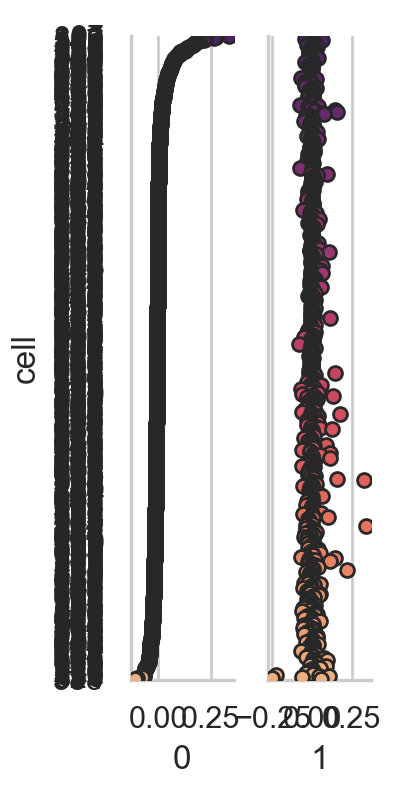

In [29]:
# Try to plot out ICA component weights - super slow
n_to_plot = 2
sns.set_theme(style='whitegrid')
g = sns.PairGrid(data=ct_df.sort_values(0, ascending=False), x_vars=ct_df.columns[0:n_to_plot], 
                 y_vars=["cell"], height=4, aspect=0.25)
g.map(sns.stripplot, orient="h", jitter=False, palette="flare_r", linewidth=1)


<IPython.core.display.Javascript object>


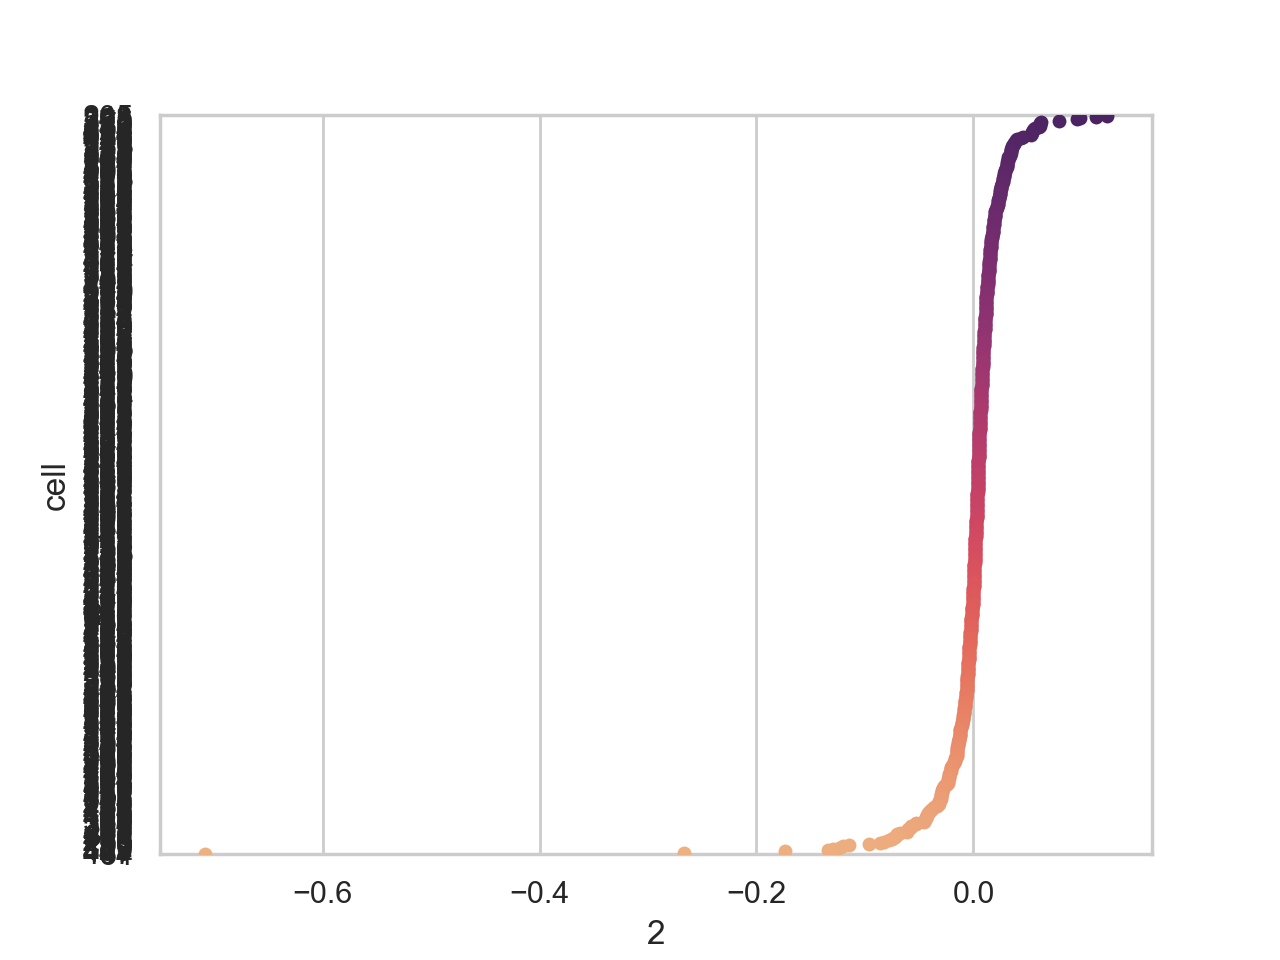

<AxesSubplot:xlabel='2', ylabel='cell'>

In [147]:
%matplotlib notebook
fig, ax = plt.subplots()
ct_df.sort_values(ica_plot, ascending=False)
sns.stripplot(data=ct_df.sort_values(ica_plot, ascending=False), y='cell', x=ica_plot, 
              orient='h', jitter=False, palette='flare_r')